구글 드라이브 마운트하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/컴퓨터비전/NetVLAD')

!pip install faiss-gpu

     |████████████████████████████████| 89.7 MB 12 kB/s 


In [3]:
cd /content/drive/My Drive/컴퓨터비전/NetVLAD

/content/drive/My Drive/컴퓨터비전/NetVLAD


In [4]:
ls -al

total 85409
-rw------- 1 root root    29840 Aug  7 07:32 berlin.mat
drwx------ 2 root root     4096 Sep 27 01:45 ckpt/
-rw------- 1 root root   100067 Sep 27 05:32 NetVLAD_base_code.ipynb
-rw------- 1 root root 87315062 Sep 26 09:37 pittsburgh_checkpoint.pth.tar
drwx------ 2 root root     4096 Sep 27 01:45 Query_resized/
drwx------ 2 root root     4096 Sep 27 01:45 Reference_resized/


할당받은 GPU 체크하기

In [5]:
!nvidia-smi

Mon Sep 27 05:32:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision

from torchvision.models import resnet18,vgg16

torch.manual_seed(777)

Loss 평균값 계산을 위한 클래스 정의 

In [7]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

NetVLAD 아키텍처 

- 해당 코드는 'https://github.com/Nanne/pytorch-NetVlad/'를 베이스로 만들어짐

In [8]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=12, dim=128, alpha=100.0,normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=False)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )

    def forward(self, x):

        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        vlad = torch.zeros([N, self.num_clusters, C], dtype=x.dtype, layout=x.layout, device=x.device)
        for C in range(self.num_clusters): # slower than non-looped, but lower memory usage 
            residual = x_flatten.unsqueeze(0).permute(1, 0, 2, 3) - \
                    self.centroids[C:C+1, :].expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
            residual *= soft_assign[:,C:C+1,:].unsqueeze(2)
            vlad[:,C:C+1,:] = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

모델 아키텍처 구축

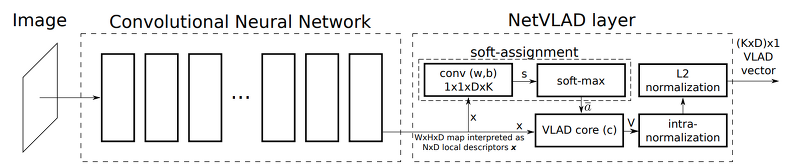

- 백본 : VGG16
- Pooling : NetVLAD

In [9]:
# VGG 16
encoder = vgg16(pretrained=True)
layers = list(encoder.features.children())[:-2]

for l in layers[:-5]: 
    for p in l.parameters():
        p.requires_grad = False

model = nn.Module() 

encoder = nn.Sequential(*layers)
model.add_module('encoder', encoder)

dim = list(encoder.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=16, dim=dim)
model.add_module('pool', net_vlad)

model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
# Pretrained Model Load(Pittsburgh 30k)
# NetVLAD는 피츠버그 데이터셋을 이용해 학습하였음, 하지만 데이터셋의 용량이 크고 학습에 필요한 하드웨어 리소스 문제로 본 챌린지에서는 사전학습된 체크포인트를 제공함

load_model = torch.load('./pittsburgh_checkpoint.pth.tar')
model.load_state_dict(load_model['state_dict'])

<All keys matched successfully>

본 챌린지에서 사용하는 'Berlin Kudamm Dataset' 로더

In [11]:
import torch.utils.data as data
import torchvision.transforms as transforms

from random import choice
from os.path import join, exists
from collections import namedtuple
from scipy.io import loadmat
from PIL import Image
from sklearn.neighbors import NearestNeighbors

root_dir = '/content/drive/My Drive/컴퓨터비전/NetVLAD' # 필요시 경로수정

def parse_dbStruct(path):
    mat = loadmat(path)

    matStruct = mat['dbStruct'][0]

    dataset = 'dataset'

    whichSet = 'VPR'

    dbImage = matStruct[0]
    locDb = matStruct[1]

    qImage = matStruct[2]
    locQ = matStruct[3]

    numDb = matStruct[4].item()
    numQ = matStruct[5].item()

    posDistThr = matStruct[6].item()
    posDistSqThr = matStruct[7].item()

    return dbStruct(whichSet, dataset, dbImage, locDb, qImage, 
            locQ, numDb, numQ, posDistThr, 
            posDistSqThr)
  
dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset',
  'dbImage', 'locDb', 'qImage', 'locQ', 'numDb', 'numQ',
  'posDistThr', 'posDistSqThr'])
  
class BerlinDataset(data.Dataset) :
  
  def __init__(self,condition='train') :
    self.dbStruct = parse_dbStruct('/content/drive/My Drive/컴퓨터비전/NetVLAD/berlin.mat') # 필요시 경로수정
    self.input_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
      ])
    
    self.condition = condition

    if self.condition == 'train' :
      self.images = [join(root_dir, dbIm.replace(' ','')) for dbIm in self.dbStruct.dbImage]
    elif self.condition == 'test' :
      self.images = [join(root_dir, qIm.replace(' ','')) for qIm in self.dbStruct.qImage]
    else :
      self.images = [join(root_dir, dbIm.replace(' ','')) for dbIm in self.dbStruct.dbImage]
    
    self.positives = None
    self.distances = None

    self.getPositives()
  
  def __getitem__(self, index):

      if self.condition == 'train' :
        img = Image.open(self.images[index])
        img = self.input_transform(img)

        pos_list = self.positives[index].tolist()
        pos_list.remove(index)
        pos_index = self.positives[index][np.random.randint(0,len(self.positives[index]))]
        pos_img = Image.open(self.images[pos_index])
        pos_img = self.input_transform(pos_img)

        pos_list = pos_list + [index]
        neg_index = choice([i for i in range(len(self.images)) if i not in pos_list])
        neg_img = Image.open(self.images[neg_index])
        neg_img = self.input_transform(neg_img)

        img = torch.stack([img,pos_img,neg_img],dim=0)
        label = torch.Tensor([0, 0, 1])

        return img, label

      elif self.condition == 'test' :
        img = Image.open(self.images[index])
        img = self.input_transform(img)

        return img
      
      else :
        img = Image.open(self.images[index])
        img = self.input_transform(img)

        return img


  def __len__(self):
      return len(self.images)

  def getPositives(self):
      # positives for evaluation are those within trivial threshold range
      #fit NN to find them, search by radius
      if  self.condition == 'train' :
          knn = NearestNeighbors(n_jobs=1)
          knn.fit(self.dbStruct.locDb)

          self.distances, self.positives = knn.radius_neighbors(self.dbStruct.locDb,radius=self.dbStruct.posDistThr)
      else :
          knn = NearestNeighbors(n_jobs=1)
          knn.fit(self.dbStruct.locDb)

          self.distances, self.positives = knn.radius_neighbors(self.dbStruct.locQ,
                  radius=self.dbStruct.posDistThr)
      
      return self.positives

In [12]:
train_dataset = BerlinDataset(condition="train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=True,num_workers=0)   

피츠버그 데이터셋기반 사전학습된 weight를 Berlin Kudamm 데이터셋 finetune

In [13]:
epochs = 5
global_batch_size = 8
lr = 0.00001
momentum = 0.9
weightDecay = 0.001
losses = AverageMeter()
best_loss = 100.0
margin = 0.1 

criterion = nn.TripletMarginLoss(margin=margin**0.5, p=2, reduction='sum').cuda()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum, weight_decay=weightDecay)

model.train()

for epoch in range(epochs):
  for batch_idx, (train_image,train_label) in enumerate(train_loader) :
    output_train = model.encoder(train_image.squeeze().cuda())
    output_train = model.pool(output_train)
    triplet_loss = criterion(output_train[0].reshape(1,-1),output_train[1].reshape(1,-1),output_train[2].reshape(1,-1))

    if batch_idx == 0 :
      optimizer.zero_grad()

    triplet_loss.backward(retain_graph=True)
    losses.update(triplet_loss.item())

    if (batch_idx +1) % global_batch_size == 0 :
      for name, p in model.named_parameters():
        if p.requires_grad:
          p.grad /= global_batch_size
    
        optimizer.step()
        optimizer.zero_grad()

    if batch_idx % 20 == 0 and batch_idx != 0:
      print('epoch : {}, batch_idx  : {}, triplet_loss : {}'.format(epoch,batch_idx,losses.avg))
  
  if best_loss > losses.avg :
    best_save_name = 'best_model.pt'
    best_path = F"./ckpt/{best_save_name}" 
    torch.save(model.state_dict(), best_path)
    
  model_save_name = 'model_{:02d}.pt'.format(epoch)
  path = F"./ckpt/{model_save_name}" 
  torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 0, batch_idx  : 20, triplet_loss : 0.14938301131838844
epoch : 0, batch_idx  : 40, triplet_loss : 0.13576155174069288
epoch : 0, batch_idx  : 60, triplet_loss : 0.1347684645261921
epoch : 0, batch_idx  : 80, triplet_loss : 0.1364912662977054
epoch : 0, batch_idx  : 100, triplet_loss : 0.13496282431158688
epoch : 0, batch_idx  : 120, triplet_loss : 0.13129425344388346
epoch : 0, batch_idx  : 140, triplet_loss : 0.13473306945029725
epoch : 0, batch_idx  : 160, triplet_loss : 0.140616906725842
epoch : 0, batch_idx  : 180, triplet_loss : 0.13875166981259762
epoch : 0, batch_idx  : 200, triplet_loss : 0.13883715749380007
epoch : 0, batch_idx  : 220, triplet_loss : 0.13538918964463661
epoch : 0, batch_idx  : 240, triplet_loss : 0.13508720516663864
epoch : 0, batch_idx  : 260, triplet_loss : 0.13525546145165104
epoch : 0, batch_idx  : 280, triplet_loss : 0.13566860355092114
epoch : 0, batch_idx  : 300, triplet_loss : 0.13962274750205766
epoch : 1, batch_idx  : 20, triplet_loss : 0.141

데이터베이스(DB) 구축 
- 모델을 통해서 얻은 글로벌 기술자를 'train_feature_list'에 저장

In [14]:
from tqdm import tqdm

cluster_dataset = BerlinDataset(condition="cluster")
cluster_loader = torch.utils.data.DataLoader(cluster_dataset, batch_size=1,shuffle=False,num_workers=0) 

train_feature_list = list()

model.eval()

with torch.no_grad():
  for batch_idx, train_image in tqdm(enumerate(cluster_loader)) :
    output_train = model.encoder(train_image.cuda())
    output_train = model.pool(output_train)
    train_feature_list.append(output_train.squeeze().detach().cpu().numpy())

train_feature_list = np.array(train_feature_list)

314it [00:47,  6.63it/s]


Query 데이터에 대해서도 글로벌 기술자를 추출하여 'test_feature_list' 에 저장

In [15]:
test_dataset = BerlinDataset(condition="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False,num_workers=0)   

In [16]:
test_feature_list = list()

with torch.no_grad():
  for batch_idx, test_image in tqdm(enumerate(test_loader)) :
    output_test = model.encoder(test_image.cuda())
    output_test = model.pool(output_test)
    test_feature_list.append(output_test.squeeze().detach().cpu().numpy())

test_feature_list = np.array(test_feature_list)

280it [01:40,  2.77it/s]


Facebook에 제작한 faiss 라이브러리 사용하여 글로벌 기술자 벡터간의 유사도 계산

In [17]:
import faiss

n_values = [1,5,10,20]

faiss_index = faiss.IndexFlatL2(train_feature_list.shape[1])
faiss_index.add(train_feature_list)
_, predictions = faiss_index.search(test_feature_list, max(n_values))

쿼리에서 추출한 글로벌 기술자에 대해서 유사도가 높은 상위 20개의 데이터 베이스 인덱스를 저장하여 json으로 제작 (이를 EvalAI에 제출)

In [19]:
import json

file_path = "./submit.json"

data = {}
data['Query'] = list()

for i in range(len(predictions)) :
  data_t = [("id",i),("positive",predictions[i].tolist())]
  data_t = dict(data_t)
  data['Query'].append(data_t)
  
with open(file_path, 'w') as outfile:
    json.dump(data, outfile, indent=4)